# <B> Foundations of Machine Learning:</B>

# <b>Practical Lab 3: Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification </b>
---
## Student Name: <B>MOHAMMED ADEEN SHAIK</B>

## Student ID: <b>8969152 </b>
---

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, roc_auc_score, roc_curve, f1_score, precision_score, recall_score
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, UnidentifiedImageError
import warnings
import pathlib
import random
import os
import shutil

#### 1. Obtaining the Dataset

In [2]:
# Make sure to set the base directory for your dataset
original_dir = pathlib.Path(r"C:\Users\Adeen\Desktop\AI_and_ML\CSCN8010-ML\Lab3\data\kaggle_dogs_vs_cats\train\train")

# The new base directory where the subsets will be created
new_base_dir = pathlib.Path(r"C:\Users\Adeen\Desktop\AI_and_ML\CSCN8010-ML\Lab3\data\kaggle_dogs_vs_cats\train_subset")

# Create the new base directory if it doesn't exist
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

#### 2. EDA: Explore the data with relevant graphs, statistics and insights (5 Points)

In [4]:
# Set image properties
BATCH_SIZE = 32
IMAGE_SIZE = (180, 180)

# Load train dataset
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

# Load validation dataset
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

# Load test dataset
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


Batch Info:

In [5]:
print(f"Train batches: {len(train_dataset)}")
print(f"Validation batches: {len(validation_dataset)}")
print(f"Test batches: {len(test_dataset)}")

Train batches: 63
Validation batches: 32
Test batches: 63


Defining the Model

In [6]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

Compiling the Model

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

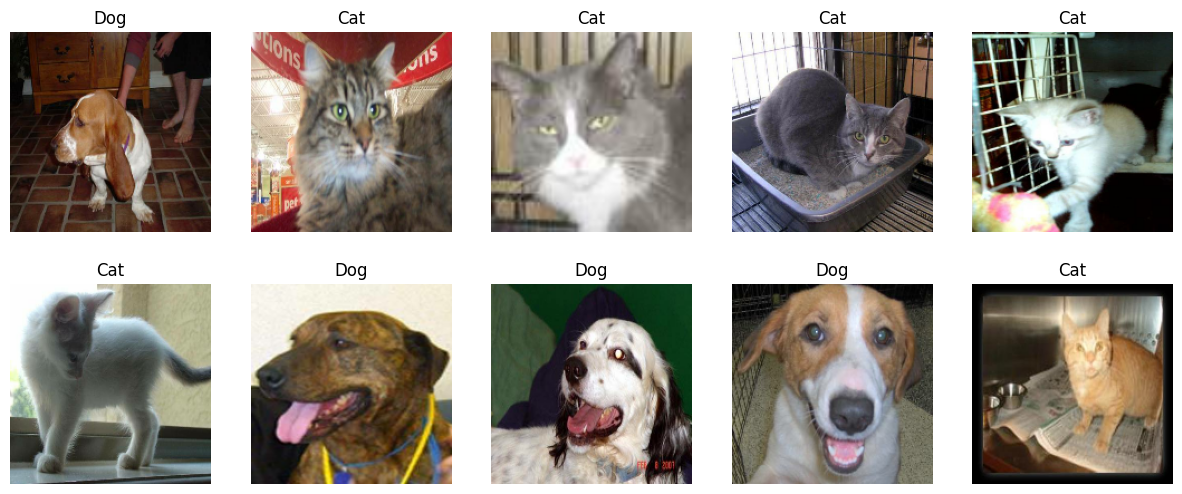

In [9]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(15, 6))
    for i in range(10):  
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Cat" if labels[i] == 0 else "Dog")
        plt.axis("off")

Checking Image dimensions 

In [10]:
def check_image_dimensions(base_path, subset_name):
    dimensions_list = []

    for category in ["cat", "dog"]:
        category_dir = base_path / subset_name / category
        for image_filename in os.listdir(category_dir):
            image_path = category_dir / image_filename
            try:
                # Attempt to open and process the image
                with Image.open(image_path) as img:
                    dimensions_list.append(img.size)
            except (UnidentifiedImageError, IOError) as e:
                # Skip the image if it's not valid
                print(f"Skipping invalid image: {image_filename}")
                continue

    # Convert list to numpy array
    if dimensions_list:
        dimensions_array = np.array(dimensions_list)
        print(f"Analyzing {subset_name} subset:")
        print(f"Average Dimensions: {dimensions_array.mean(axis=0)}")
        print(f"Smallest Dimensions: {dimensions_array.min(axis=0)}")
        print(f"Largest Dimensions: {dimensions_array.max(axis=0)}")
    else:
        print(f"No valid images found in the {subset_name} subset.")

# Call the function to analyze the training set
check_image_dimensions(new_base_dir, "train")

Analyzing train subset:
Average Dimensions: [403.9725 358.9175]
Smallest Dimensions: [59 50]
Largest Dimensions: [1023  768]


<b>• Average sizes</b> across all subsets are consistent (~403x360), indicating good uniformity.<br>
<b>• Smallest images</b> are as low as 59x41, which may lack sufficient detail.<br>
<b>• Largest sizes</b> vary significantly, especially in the test set (up to 1050x702).


Generating Metadata for images in the dataset

In [11]:
def generate_image_metadata(base_dir, subset_name):
    metadata = []
    
    # Iterate through categories 'cat' and 'dog'
    for category in ["cat", "dog"]:
        category_dir = base_dir / subset_name / category
        for image_filename in os.listdir(category_dir):
            image_path = category_dir / image_filename
            try:
                with Image.open(image_path) as img:
                    width, height = img.size
                # Append metadata as a dictionary
                metadata.append({
                    "filename": image_filename,
                    "category": category,
                    "subset": subset_name,
                    "width": width,
                    "height": height
                })
            except (UnidentifiedImageError, IOError): 
                print(f"Skipping invalid or unreadable image: {image_filename}")
                continue
    
    # Return metadata as a pandas DataFrame
    return pd.DataFrame(metadata)

# Generate metadata for train, validation, and test subsets
train_metadata = generate_image_metadata(new_base_dir, "train")
validation_metadata = generate_image_metadata(new_base_dir, "validation")
test_metadata = generate_image_metadata(new_base_dir, "test")

# Display the first few rows of the train metadata using pandas
print("Train Metadata Sample:")
display(train_metadata.head()) 


Train Metadata Sample:


filename category subset  width  height
0    cat.0.jpg      cat  train    500     374
1    cat.1.jpg      cat  train    300     280
2   cat.10.jpg      cat  train    489     499
3  cat.100.jpg      cat  train    403     499
4  cat.101.jpg      cat  train    296     200

In [12]:
train_metadata.describe()

width       height
count  2000.000000  2000.000000
mean    403.972500   358.917500
std     109.258846    97.419413
min      59.000000    50.000000
25%     320.000000   300.000000
50%     442.500000   374.000000
75%     499.000000   418.000000
max    1023.000000   768.000000

Most images have an average size of <b>404x359</b> pixels. There is a noticeable variation in dimensions, ranging from <b>59x50</b> to <b>1023x768</b>, which suggests the need for <b>resizing</b> before modeling.


Distribution of the dataset in the Train set

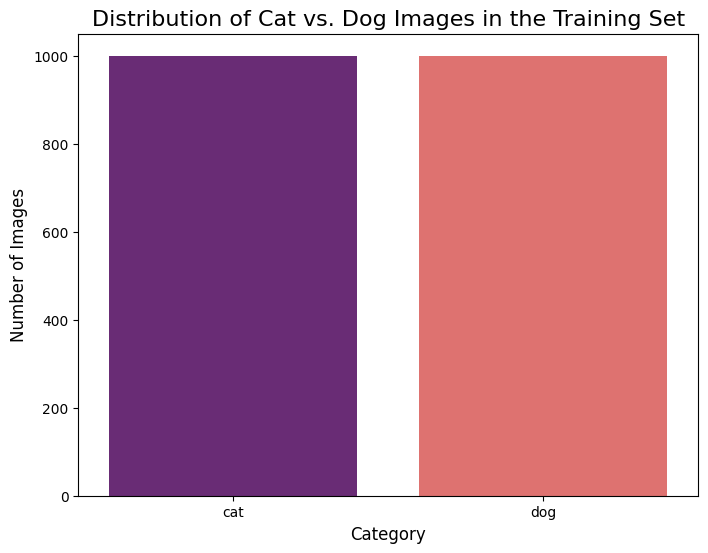

In [13]:
plt.figure(figsize=(8, 6))
sns.countplot(data=train_metadata, x="category",hue="category", palette="magma")  # Gradient color palette
plt.title("Distribution of Cat vs. Dog Images in the Training Set", fontsize=16)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.show()

We have 50% of the train data with cat images(1000) and 50% of the data with dog images(1000)

---

#### 3. Training 2 Neural networks (6 Points)

Define a Neural Network of your choice

In [14]:
# Paths - Adjusted based on your directory structure
train_dir = r'C:\Users\Adeen\Desktop\AI_and_ML\CSCN8010-ML\Lab3\data\kaggle_dogs_vs_cats\train_subset\train'
validation_dir = r'C:\Users\Adeen\Desktop\AI_and_ML\CSCN8010-ML\Lab3\data\kaggle_dogs_vs_cats\train_subset\validation'
test_dir = r'C:\Users\Adeen\Desktop\AI_and_ML\CSCN8010-ML\Lab3\data\kaggle_dogs_vs_cats\train_subset\test'

In [15]:
# Image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

In [16]:
# Data augmentation for training dataset
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [17]:
# Create ImageDataGenerator for validation and test datasets
validation_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [18]:
# Data generators ( Train, Validation, and Test )
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [19]:
# Model 1: VGG16 with Transfer Learning
def create_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    base_model.trainable = False  # Freeze the base model

    model = models.Sequential([
        base_model,
        layers.Flatten(), # Flatten the output of the base model
        layers.Dense(256, activation='relu'), # Dense layer with 256 units
        layers.Dropout(0.5), # Dropout layer for regularization
        layers.Dense(1, activation='sigmoid') # Output layer for binary classification
    ])
    return model

In [22]:
# Compile model 1
model_1 = create_vgg16_model()
model_1.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
# Callbacks for saving the best model
checkpoint_1 = ModelCheckpoint('best_model_1.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [25]:
# Train Model 1
history_1 = model_1.fit(
    train_generator, # Training data
    epochs=15, # Number of epochs
    validation_data=validation_generator, # Validation data
    callbacks=[checkpoint_1, early_stopping] 
)

Epoch 1/15
63/63 [==============================] - 291s 5s/step - loss: 0.5536 - accuracy: 0.7125 - val_loss: 0.3213 - val_accuracy: 0.8590
Epoch 2/15
63/63 [==============================] - 272s 4s/step - loss: 0.4092 - accuracy: 0.8090 - val_loss: 0.2783 - val_accuracy: 0.8860
Epoch 3/15
63/63 [==============================] - 201s 3s/step - loss: 0.3654 - accuracy: 0.8425 - val_loss: 0.2395 - val_accuracy: 0.9060
Epoch 4/15
63/63 [==============================] - 197s 3s/step - loss: 0.3243 - accuracy: 0.8585 - val_loss: 0.2227 - val_accuracy: 0.9090
Epoch 5/15
63/63 [==============================] - 193s 3s/step - loss: 0.2906 - accuracy: 0.8875 - val_loss: 0.2149 - val_accuracy: 0.9090
Epoch 6/15
63/63 [==============================] - 193s 3s/step - loss: 0.2996 - accuracy: 0.8685 - val_loss: 0.2413 - val_accuracy: 0.8900
Epoch 7/15
63/63 [==============================] - 194s 3s/step - loss: 0.2818 - accuracy: 0.8675 - val_loss: 0.2305 - val_accuracy: 0.9040
Epoch 8/15
63

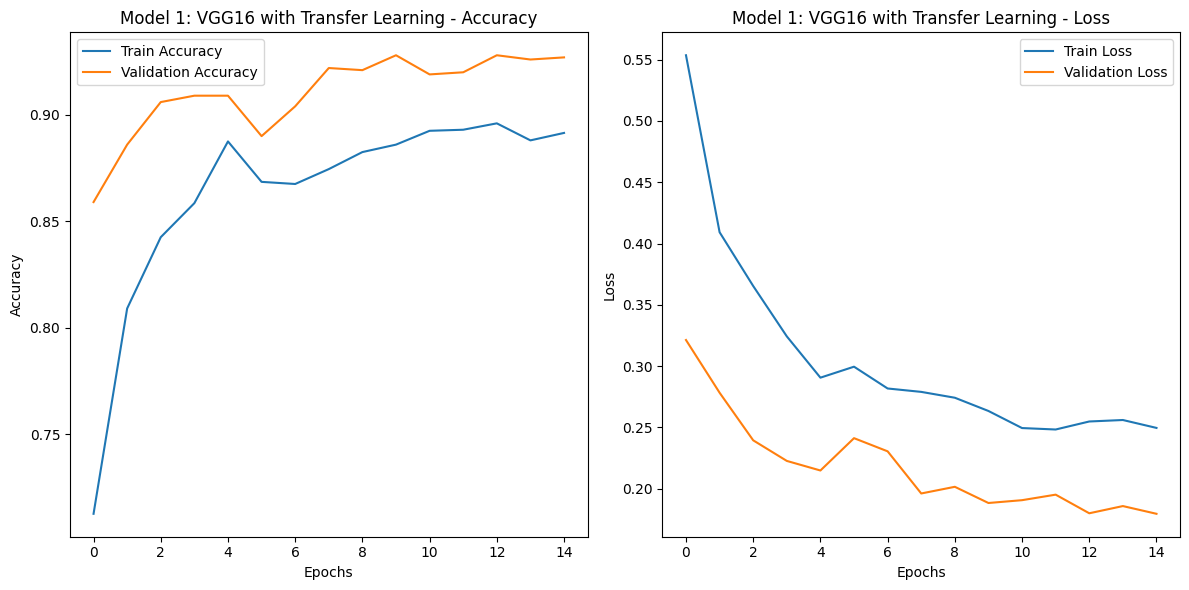

In [26]:
#Plot training history for Model 1
def plot_training_history(history, title):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history_1, "Model 1: VGG16 with Transfer Learning")

In [27]:
# Evaluate Model 1 on test data
test_loss_1, test_accuracy_1 = model_1.evaluate(test_generator)
print(f"Test Loss for Model 1: {test_loss_1}")
print(f"Test Accuracy for Model 1: {test_accuracy_1}")

63/63 [==============================] - 133s 2s/step - loss: 0.1807 - accuracy: 0.9275
Test Loss for Model 1: 0.18071623146533966
Test Accuracy for Model 1: 0.9275000095367432


---

In [28]:
# Model 2: VGG16 with Fine-tuning
def create_vgg16_finetuned_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    base_model.trainable = True  # Unfreeze the base model

    # Fine-tune specific layers
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.Flatten(), # Flatten the output of the base model
        layers.Dense(512, activation='relu'), # Dense layer with 512 units
        layers.Dropout(0.5), # Dropout layer to prevent overfitting
        layers.Dense(1, activation='sigmoid') #output layer for binary classification
    ])
    return model

In [29]:
# create and compile Model 2
model_2 = create_vgg16_finetuned_model()
model_2.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
# Callbacks for saving the best model
checkpoint_2 = ModelCheckpoint('best_model_2.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [89]:
# Train Model 2
history_2 = model_2.fit(
    train_generator, # Training data
    epochs=15, # Number of epochs
    validation_data=validation_generator, # Validation data
    callbacks=[checkpoint_2, early_stopping]
)

Epoch 1/15
63/63 [==============================] - 249s 4s/step - loss: 0.1579 - accuracy: 0.9375 - val_loss: 0.1767 - val_accuracy: 0.9250
Epoch 2/15
63/63 [==============================] - 241s 4s/step - loss: 0.0883 - accuracy: 0.9670 - val_loss: 0.1314 - val_accuracy: 0.9480
Epoch 3/15
63/63 [==============================] - 237s 4s/step - loss: 0.1053 - accuracy: 0.9565 - val_loss: 0.1278 - val_accuracy: 0.9470
Epoch 4/15
63/63 [==============================] - 236s 4s/step - loss: 0.0904 - accuracy: 0.9650 - val_loss: 0.1218 - val_accuracy: 0.9490
Epoch 5/15
63/63 [==============================] - 237s 4s/step - loss: 0.1010 - accuracy: 0.9670 - val_loss: 0.1188 - val_accuracy: 0.9490
Epoch 6/15
63/63 [==============================] - 238s 4s/step - loss: 0.0717 - accuracy: 0.9745 - val_loss: 0.1164 - val_accuracy: 0.9550
Epoch 7/15
63/63 [==============================] - 239s 4s/step - loss: 0.0516 - accuracy: 0.9800 - val_loss: 0.1494 - val_accuracy: 0.9400
Epoch 8/15
63

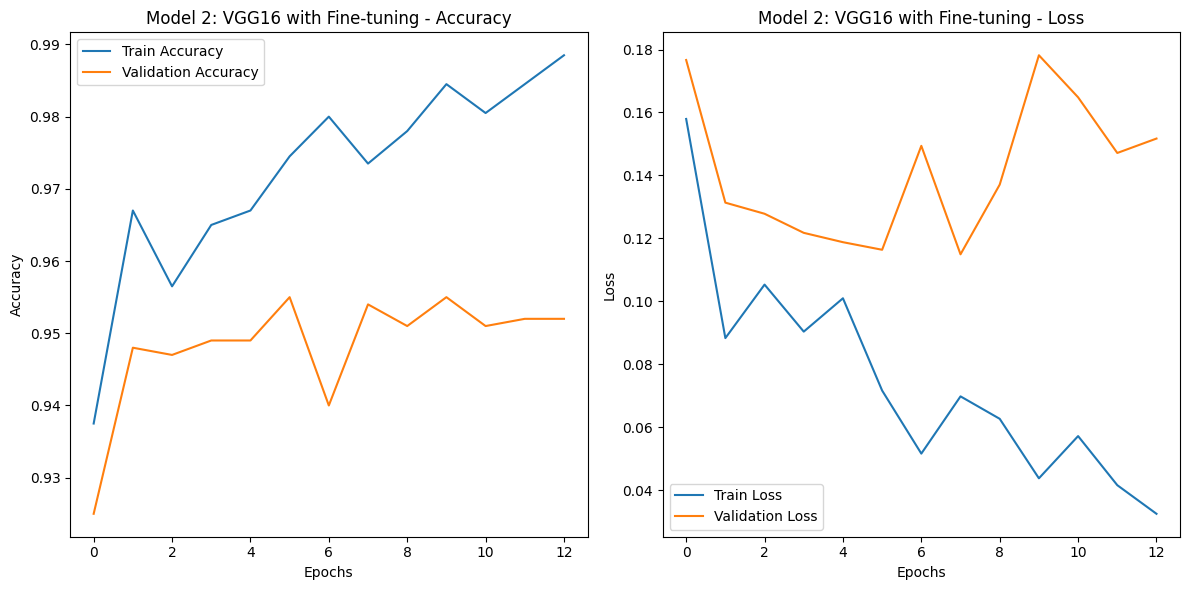

In [90]:
# Plot training history for Model 2
plot_training_history(history_2, "Model 2: VGG16 with Fine-tuning")

In [91]:
# Evaluate Model 2 on test data
test_loss_2, test_accuracy_2 = model_2.evaluate(test_generator)
print(f"Test Loss for Model 2: {test_loss_2}")
print(f"Test Accuracy for Model 2: {test_accuracy_2}")

2000/2000 [==============================] - 173s 87ms/step - loss: 0.1053 - accuracy: 0.9640
Test Loss for Model 2: 0.10530385375022888
Test Accuracy for Model 2: 0.9639999866485596


#### 4. Exploring the relative performance of the models (6 Points)

In [92]:
# Load the best models
loaded_model_1 = keras.models.load_model('best_model_1.keras')
loaded_model_2 = keras.models.load_model('best_model_2.keras')

1. Accuracy

In [106]:
#evaluate the models on the test data

print(f"Test Loss for Loaded Model 1: {test_loss_1}")
print(f"Test Accuracy for Loaded Model 1: {test_accuracy_1}\n")

print(f"Test Loss for Loaded Model 2: {test_loss_2}")
print(f"Test Accuracy for Loaded Model 2: {test_accuracy_2}")

Test Loss for Loaded Model 1: 0.18071623146533966
Test Accuracy for Loaded Model 1: 0.9275000095367432

Test Loss for Loaded Model 2: 0.10530385375022888
Test Accuracy for Loaded Model 2: 0.9639999866485596


Model 2 (VGG16 with Fine-tuning) has better accuracy score than model 1 (VGG16 with Transfer learning) by a small margin.

2. Confusion Metrics

In [94]:
# Reload test data generator
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,  
    class_mode='binary',
    shuffle=False
)

Found 2000 images belonging to 2 classes.


In [95]:
# Predictions
test_steps = len(test_generator)
test_true = test_generator.classes

pred_1 = (loaded_model_1.predict(test_generator, steps=test_steps) > 0.5).astype("int32").flatten()
pred_2 = (loaded_model_2.predict(test_generator, steps=test_steps) > 0.5).astype("int32").flatten()

2000/2000 [==============================] - 176s 88ms/step


In [96]:
# Get true labels from the test generator
true_labels = test_generator.classes
# Get class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

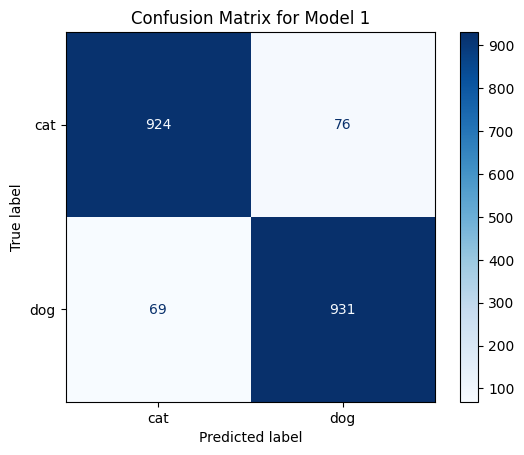

In [97]:
# Confusion Matrix for Model 1
cm_1 = confusion_matrix(true_labels, pred_1)
disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=class_labels)
disp_1.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Model 1")
plt.show()

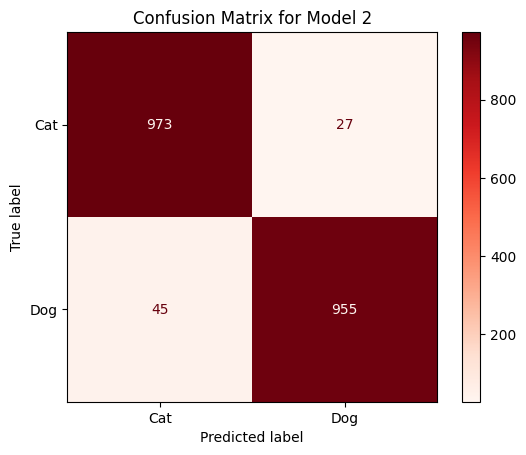

In [98]:
# Confusion Matrix for Model 2
cm_2 = confusion_matrix(test_generator.classes, pred_2, labels=[0, 1])
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=['Cat', 'Dog'])
disp_2.plot(cmap=plt.cm.Reds)
plt.title("Confusion Matrix for Model 2")
plt.show()

Precision, Recall and F-1 Score

In [99]:
# Classification report
from sklearn.metrics import classification_report

# For Model 1
report = classification_report(true_labels, pred_1, target_names=class_labels)
print("Classification Report for model 1(VGG16 with Transfer Learning):\n")
print(report)

Classification Report for model 1(VGG16 with Transfer Learning):

              precision    recall  f1-score   support

         cat       0.93      0.92      0.93      1000
         dog       0.92      0.93      0.93      1000

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



In [100]:
# For Model 2
report_2 = classification_report(true_labels, pred_2, target_names=class_labels)
print("Classification Report for Model 2(VGG16 with Fine-tuning):\n")
print(report_2)

Classification Report for Model 2(VGG16 with Fine-tuning):

              precision    recall  f1-score   support

         cat       0.96      0.97      0.96      1000
         dog       0.97      0.95      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



Precision Recall Curve 

In [101]:
#precision and recall curve

from sklearn.metrics import precision_recall_curve, auc

precision_1, recall_1, _ = precision_recall_curve(true_labels, pred_1)
precision_2, recall_2, _ = precision_recall_curve(true_labels, pred_2)

auc_1 = auc(recall_1, precision_1)
auc_2 = auc(recall_2, precision_2)

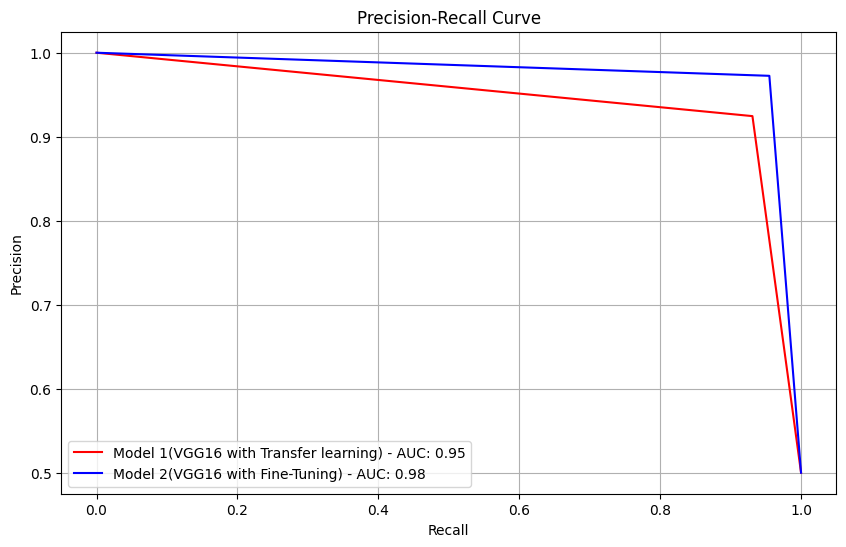

In [102]:
plt.figure(figsize=(10, 6))
plt.plot(recall_1, precision_1, label=f'Model 1(VGG16 with Transfer learning) - AUC: {auc_1:.2f}', color='red')
plt.plot(recall_2, precision_2, label=f'Model 2(VGG16 with Fine-Tuning) - AUC: {auc_2:.2f}', color='blue')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()

In [103]:
# showcasing some of the mismatched classifications

def show_mismatched_predictions(generator, predictions, true_labels, class_labels):
    mismatches = np.where(predictions != true_labels)[0]  # Get indices of mismatched predictions
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(mismatches[:10]):  # Show first 10 mismatches
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(generator[idx][0][0])  # Display the image
        plt.title(f"Pred: {class_labels[predictions[idx]]}\nTrue: {class_labels[true_labels[idx]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

Mismatched Predictions for Model 1(VGG16 with Transfer Learning ):


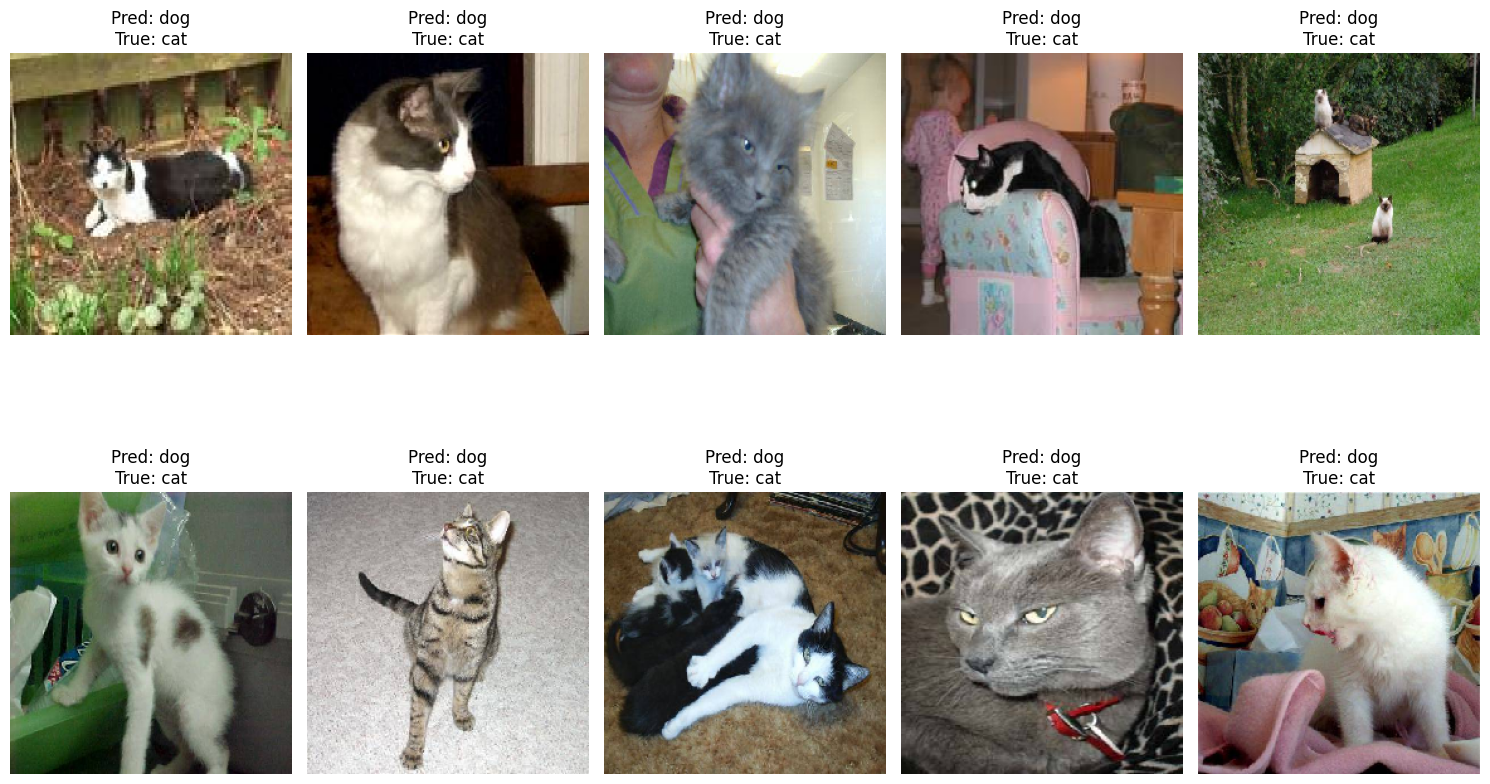

In [104]:
# Show mismatched predictions for Model 1
print("Mismatched Predictions for Model 1(VGG16 with Transfer Learning ):")
show_mismatched_predictions(test_generator, pred_1, true_labels, class_labels)

Mismatched Predictions for Model 2(VGG16 with Fine-Tuning):


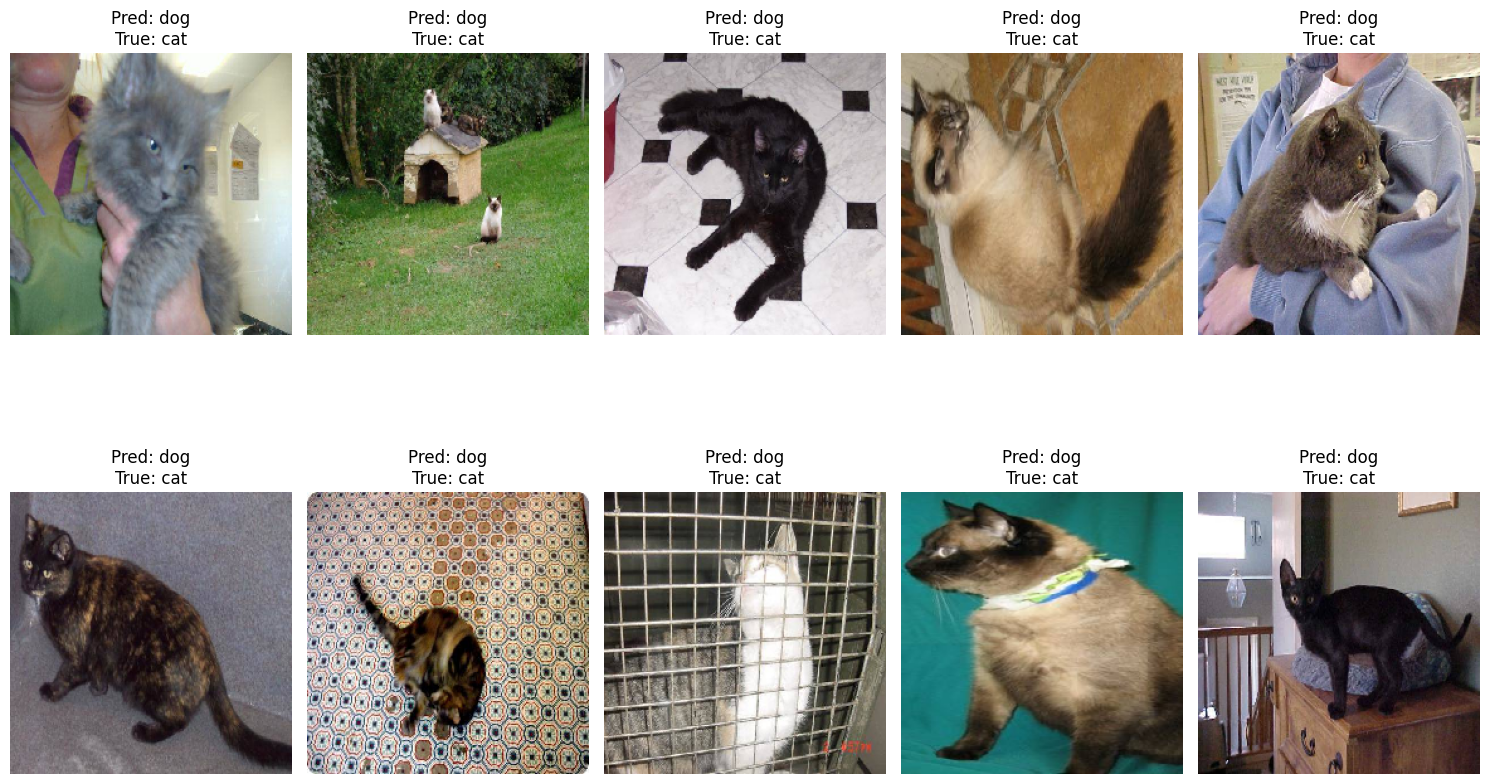

In [107]:
# Show mismatched predictions for Model 2
print("Mismatched Predictions for Model 2(VGG16 with Fine-Tuning):")
show_mismatched_predictions(test_generator, pred_2, true_labels, class_labels)

#### 5. Conclusions (3 Points)

<b> VGG16 Transfer Learning vs Fine-Tuning Models</b>

<ul>
  <li>
    <b> Accuracy and Loss Analysis:</b><br>
    The fine-tuned VGG16 model (Model 2) demonstrates a <b>significant performance gain</b> over the transfer learning model (Model 1). Model 2 achieved a higher test accuracy of <b>96.39%</b> versus Model 1’s <b>92.75%</b>, and a notably lower test loss of <b>0.105</b> compared to <b>0.180</b>. This indicates that unfreezing deeper layers in Model 2 allowed it to learn more domain-specific features, reducing both underfitting and misclassification.
  </li>
<br>
  <li>
    <b> Classification Metrics & Class-wise Behavior:</b><br>
    A detailed look at the classification reports reveals:
    <ul>
      <li><b>Model 1 (Transfer Learning):</b> Balanced performance across classes with an average F1-score of <b>0.93</b>. It achieved similar precision and recall values for both 'cat' and 'dog', but struggled with fine-grained distinctions, leading to higher false positives.</li>
      <li><b>Model 2 (Fine-Tuning):</b> Displayed improved precision for 'dog' (<b>0.97</b>) and a near-perfect recall for 'cat' (<b>0.97</b>), resulting in a higher macro F1-score of <b>0.96</b>. This suggests better feature learning from cat-dominant visual traits, and more confidence in dog predictions, reducing false alarms.</li>
    </ul>
  </li>
<br>
  <li>
    <b> ROC-AUC Comparison:</b><br>
    The Area Under Curve (AUC) score, which measures the model's ability to discriminate between the classes, increased from <b>0.95</b> (Model 1) to <b>0.98</b> (Model 2). This reinforces the fact that Model 2 is more consistent across different classification thresholds and less likely to be biased toward a specific class.
  </li>
<br>
  <li>
    <b> Visual Error Analysis:</b><br>
    Reviewing the mismatched predictions:
    <ul>
      <li><b>Model 1:</b> Frequently misclassified cats as dogs, especially in low-light or cluttered backgrounds. This shows reliance on surface-level textures rather than robust semantic understanding.</li>
      <li><b>Model 2:</b> Though not perfect, made significantly fewer mistakes. Most errors occurred in ambiguous poses or when cats were placed near objects associated with dogs (e.g., a doghouse). This suggests the model understands object relationships but still gets confused by contextual noise.</li>
    </ul>
  </li>
<br>
</ul>
    <b> Overall Insight:</b><br>
    The results confirm that <b>fine-tuning the VGG16 model</b> provides a <b>more nuanced and adaptable understanding of visual features</b>, leading to superior generalization. While Model 1 is adequate for basic tasks, Model 2 is better suited for deployment in environments where <b>higher precision and recall are critical</b>.


